In [2]:
class blief_based_q_agent():
    def __init__(self, discount_factor, num_episodes,alpha, environment):
        self.discount_factor = discount_factor
        self.num_episodes = num_episodes
        self.env = environment
        self.alpha = alpha
        self.scale = 20

     # Function for get single state
    def get_single_state(self, state):
        new_state = []
        for position in range(len(state)):
            new_value = (state[position] + 2)
            if new_value < 0 :
              new_value = 0
            if new_value > 4 :
              new_value = 4
            new_state.append(int(round(new_value, 0)))
        single_state = int(new_state[0]/0.2   - 1 )*self.scale + int(new_state[1]/0.2) -1

        return single_state


    def epsilon_greedy(self,Q, epsilon, n_actions, state, action2):

        if np.random.rand() < epsilon:
            action = np.random.randint(0, n_actions)
        else:
            action = np.argmax([Q[state][i][action2] for i in range(n_actions)])
        return action

    def sarsa(self,env, alpha, gamma,  episodes):

        n_states, n_actions = 400,5
        Qa = np.zeros((n_states, n_actions, n_actions))
        Qb = np.zeros((n_states, n_actions, n_actions))
        epsilons = 0.55
        timestep_reward1 = []
        timestep_reward2 = []
        a2 = np.random.randint(0, n_actions)
        a1_acc = [0 for i in range(n_actions)]
        a2_acc = [0 for i in range(n_actions)]
        for episode in range(episodes):
            print(f"Episode: {episode}")

            observation, infos = env.reset(seed=42)
            s1, s2 = self.get_single_state(observation['adversary_0'].tolist()), self.get_single_state(observation['agent_0'].tolist())
            t = 0
            total_reward1 = 0
            total_reward2 = 0
            if (episode+1)% 1500 == 0 :
              epsilons *= 0.5
            while env.agents:
                a1 = self.epsilon_greedy(Qa, epsilons, n_actions, s1 , a2)
                a2 = self.epsilon_greedy(Qb, epsilons, n_actions, s2, a1)
                t += 1
                actions = {'adversary_0': 0, 'agent_0': 0}
                actions['adversary_0'] = a1
                actions['agent_0'] = a2
                s_, reward, terminations, truncations, infos = env.step(actions)
                a1_acc[a1] +=1
                a2_acc[a2] +=1
                s_1, s_2 =  self.get_single_state(observation['adversary_0'].tolist()),  self.get_single_state(observation['agent_0'].tolist())
                reward1, reward2 = reward["adversary_0"], reward["agent_0"]
                total_reward1 += reward1
                total_reward2 += reward2


                aa_ = np.argmax([np.sum([Qa[s_1][i][j]*a2_acc[j] for j in range(n_actions)]) for i in range(n_actions)])
                ab_ = np.argmax([np.sum([Qb[s_2][i][j]*a1_acc[j] for j in range(n_actions)]) for i in range(n_actions)])

                # v[state_p] = np.argmax([np.sum([Q_sa[i][j][state]*p[j] for j in range(self.action_count)]) for i in range(self.action_count)])

                Qa[s1, a1, a2] = (1- alpha) *Qa[s1, a1, a2]  + alpha * ( reward1+ (gamma * Qa[s_1, aa_, ab_])  )
                Qb[s2, a2, a1] = (1 - alpha)* Qb[s2, a2, a1] + alpha * ( reward2 + (gamma * Qb[s_2,ab_, aa_])  )
                s1, s2=  s_1, s_2
            print(f"This episode took {t} timesteps and reward1: {total_reward1} reward2: {total_reward2}")
            timestep_reward1.append(total_reward1)
            timestep_reward2.append(total_reward2)

        return timestep_reward1, timestep_reward2



    def take_action(self):

        rewards = self.sarsa(self.env, self.alpha, self.discount_factor, self.num_episodes)

        return rewards

In [3]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.0 MB/s eta 0:00:00


In [4]:
enum_action = { 0: "DO_nothing", 0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP" }


import gymnasium as gym
from gymnasium.utils.save_video import save_video
import numpy as np
import time


# hyperparameters
REPS = 20
EPISODES = 3000
EPSILON = 0.8
LEARNING_RATE = 0.1
DISCOUNT = 0.9
scale = 20


In [5]:
!pip install 'pettingzoo[mpe]'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [6]:
from pettingzoo.mpe import simple_adversary_v3,simple_v3


env = simple_adversary_v3.parallel_env(N=1 ,max_cycles=25, continuous_actions=False,render_mode="human")
env.reset(seed=42)



({'adversary_0': array([-1.3595574 ,  1.0734879 ,  0.16928375,  0.51697916], dtype=float32),
  'agent_0': array([-1.5288411 ,  0.55650866, -1.5288411 ,  0.55650866, -0.16928375,
         -0.51697916], dtype=float32)},
 {'adversary_0': {}, 'agent_0': {}})

In [7]:
for agent in env.agents:
    print(agent, env.observation_space(agent).shape[0])
    observ_space_num =env.observation_space(agent).shape[0]


adversary_0 4
agent_0 6


In [8]:
for agent in env.agents:
    print(agent, env.action_space(agent).n)
    action_space_num =env.action_space(agent).n


adversary_0 5
agent_0 5


In [10]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
# hyperparameters
REPS = 20
EPISODES = 3000
EPSILON = 0.8
LEARNING_RATE = 0.1
DISCOUNT = 0.9
scale = 20

qlearn = blief_based_q_agent(DISCOUNT ,EPISODES ,LEARNING_RATE , env)
r1_minmax, r2_minmax = qlearn.take_action()


[]

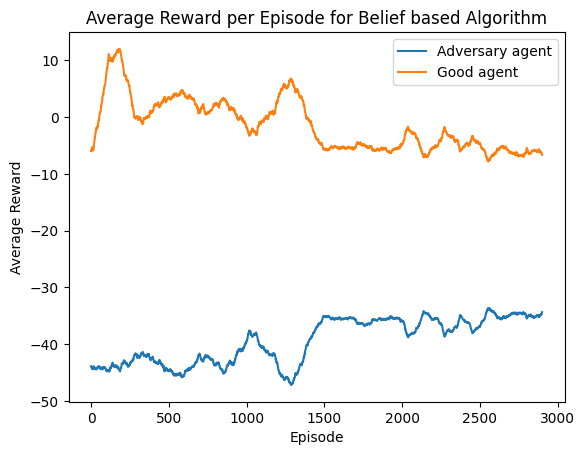

In [15]:
import matplotlib.pyplot as plt

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.plot(moving_average(r1_minmax, n=100), label = 'Adversary agent')
plt.plot(moving_average(r2_minmax, n=100), label='Good agent')
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward per Episode for Belief based Algorithm")
plt.legend()
plt.plot()

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(moving_average(total_rewards, n=100))
